## Segment Classification

In [6]:
# Import useful libraries

import os

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

import matplotlib.pyplot as plt
import numpy as np

## Trying a pretrained model: VGG16

> First of all, we need to check if the segments of the image can be classified correctly using a pretained model. Otherwise, we will need to fine tune it or use another method.

In [7]:
# Load  the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=True)

1/1 [==============================] - 1s 538ms/step
1: perfume
2: vase
3: whiskey_jug


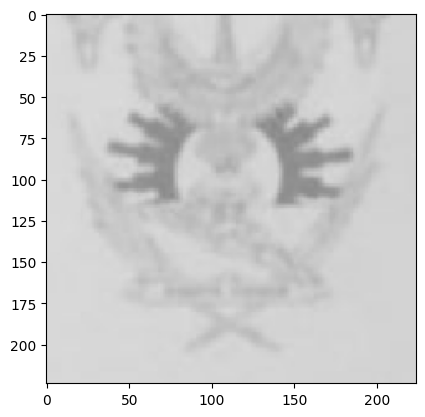

1/1 [==============================] - 0s 90ms/step
1: cassette
2: web_site
3: plate_rack


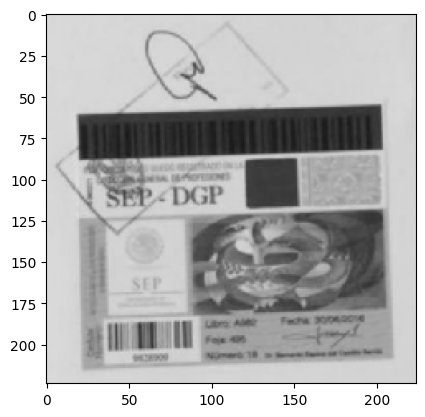

1/1 [==============================] - 0s 82ms/step
1: airship
2: snowplow
3: tank


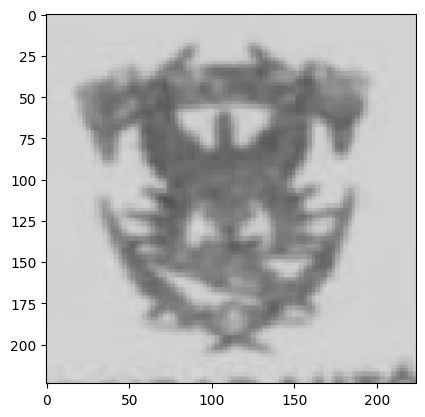

1/1 [==============================] - 0s 100ms/step
1: screw
2: ballpoint
3: plate_rack


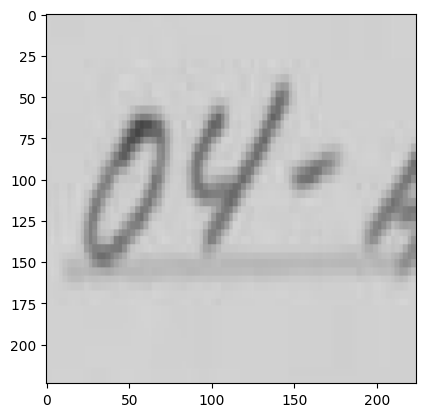

1/1 [==============================] - 0s 85ms/step
1: quill
2: bow
3: plate_rack


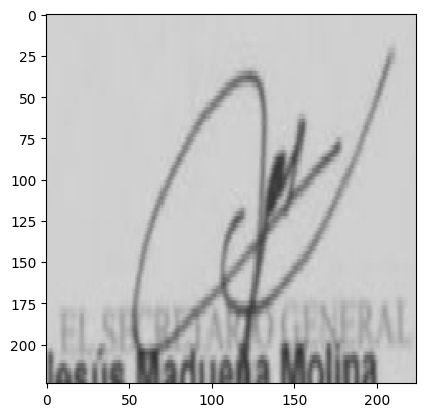

1/1 [==============================] - 0s 89ms/step
1: web_site
2: book_jacket
3: envelope


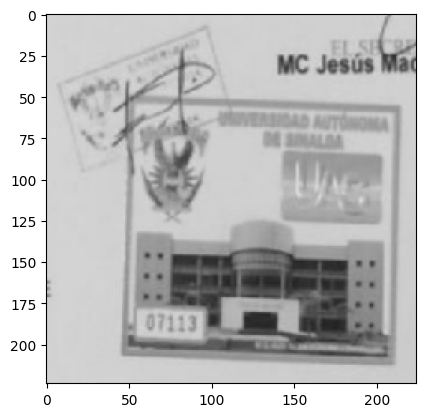

1/1 [==============================] - 0s 95ms/step
1: airship
2: screw
3: book_jacket


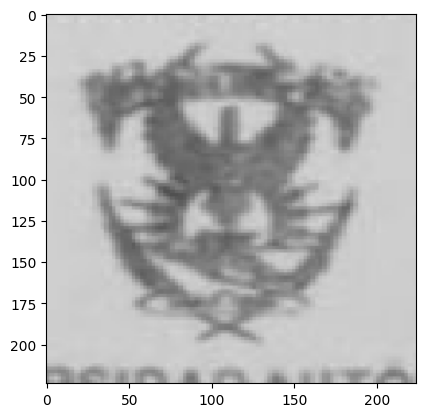

1/1 [==============================] - 0s 68ms/step
1: safety_pin
2: lab_coat
3: measuring_cup


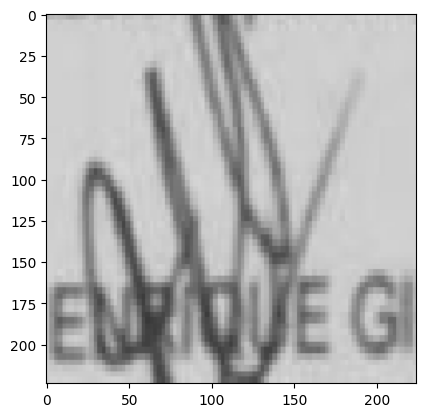

In [8]:
# Test the model with samples images

img_folder = "crops/"

for file_name in os.listdir(img_folder):

    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        
        file_path = os.path.join(img_folder, file_name)
        img = image.load_img(file_path, target_size=(224, 224))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # print(x.shape)

        predictions = base_model.predict(x)

        decoded_classes = decode_predictions(predictions, top=3)[0]

        for i, (imagenet_id, label, score) in enumerate(decoded_classes):
            print(f"{i + 1}: {label}")

        plt.imshow(img)
        plt.show()

> As it can be seen below, using a pretrained model without any modification is not a good option.

## Fine-tuning the model

In [30]:
dataset_path = r"Google Images/"

class_to_label = {}
label_to_class = {}

for i, class_folder in enumerate(os.listdir(dataset_path)):
    class_to_label[class_folder] = i
    label_to_class[i] = class_folder

print(class_to_label)

{'BarCodes': 0, 'Graphs': 1, 'LogosAndStamps': 2, 'Photographs': 3, 'QRcodes': 4, 'Signatures': 5}


In [31]:
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

images = []
labels = []

for class_folder, label in class_to_label.items():
    class_path = os.path.join(dataset_path, class_folder)
    
    # non-directory files
    if not os.path.isdir(class_path):
        continue

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        img = image.load_img(image_path, target_size=(224, 224))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        images.append(x)
        labels.append(label)

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
labels = np.array(labels)

In [32]:
images.shape, labels.shape

((282, 224, 224, 3), (282,))

In [33]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [34]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42) 

In [35]:
class_to_label 

{'BarCodes': 0,
 'Graphs': 1,
 'LogosAndStamps': 2,
 'Photographs': 3,
 'QRcodes': 4,
 'Signatures': 5}

In [36]:
from keras.utils import to_categorical

# One-hot encode the labels
num_classes = len(class_to_label)
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [37]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load the pre-trained VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Assuming num_classes is defined earlier
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=8, validation_data=(val_images, val_labels), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


Epoch 1/10
29/29 [==============================] - 11s 363ms/step - loss: 7.8104 - accuracy: 0.7733 - val_loss: 5.3343 - val_accuracy: 0.8571
Epoch 2/10
29/29 [==============================] - 11s 372ms/step - loss: 0.7362 - accuracy: 0.9600 - val_loss: 3.9854e-04 - val_accuracy: 1.0000
Epoch 3/10
29/29 [==============================] - 11s 381ms/step - loss: 0.0531 - accuracy: 0.9956 - val_loss: 0.4620 - val_accuracy: 0.9643
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.0


1/1 [==============================] - 1s 1s/step


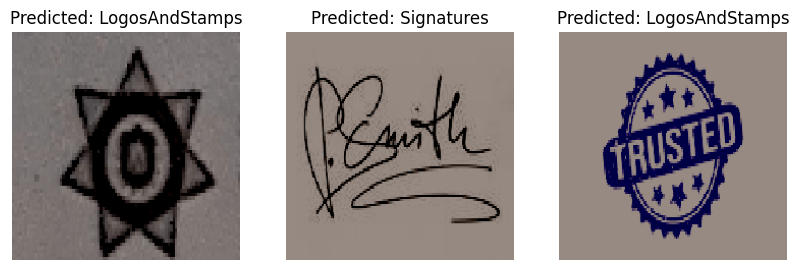

In [38]:
# Visualize the model's performance using test data

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
labels = [label_to_class[label] for label in predicted_labels]

plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_images[i].clip(0, 255).astype(np.uint8))
    plt.title(f"Predicted: {labels[i]}")
    plt.axis('off')

In [39]:
# Save model weights, just in case
model.save_weights('model_weights.h5')

In [8]:
# Model to binary file! not h5 standalone file



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 21139014 (80.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Save CONFIGURATION
model_config = model.to_json()
with open('model_config.json', 'w') as file:
    file.write(model_config)
    

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image
from keras.layers import Dense

import numpy as np
import cv2
import os

import json

In [2]:
dataset_path = r"Google Images/"

class_to_label = {}
label_to_class = {}

for i, class_folder in enumerate(os.listdir(dataset_path)):
    class_to_label[class_folder] = i
    label_to_class[i] = class_folder

num_classes = len(class_to_label)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

model.load_weights('model_weights.h5')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
class_to_label

{'BarCodes': 0,
 'Graphs': 1,
 'LogosAndStamps': 2,
 'Photographs': 3,
 'QRcodes': 4,
 'Signatures': 5}

1/1 [==============================] - 0s 439ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


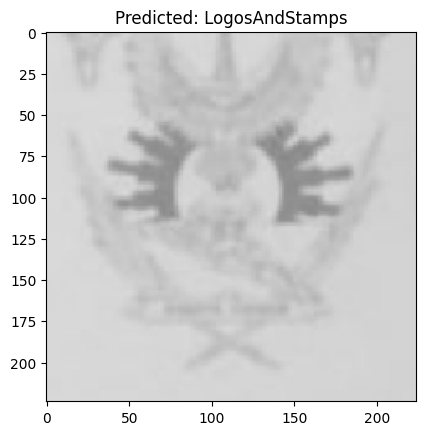

1/1 [==============================] - 0s 72ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


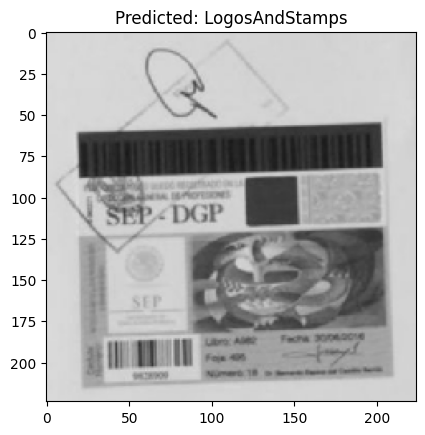

1/1 [==============================] - 0s 73ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


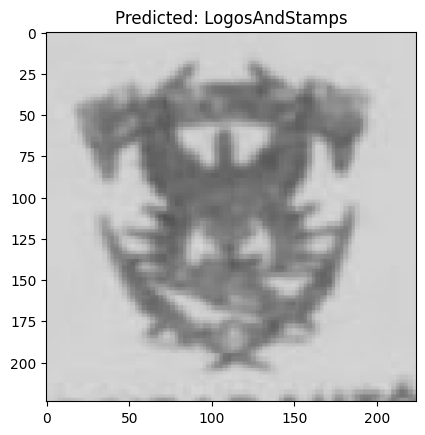

1/1 [==============================] - 0s 73ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


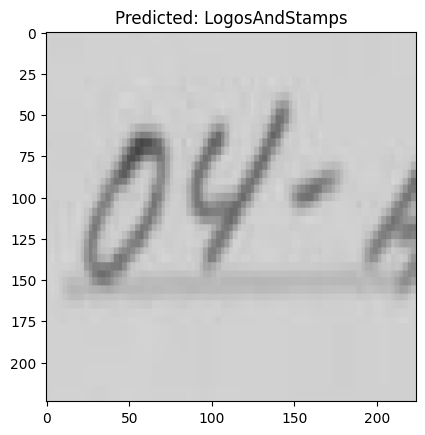

1/1 [==============================] - 0s 81ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 0.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 1.0000


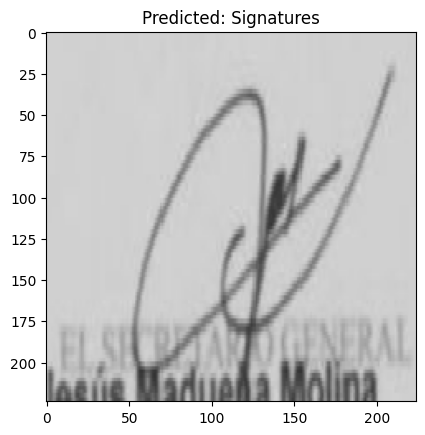

1/1 [==============================] - 0s 66ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


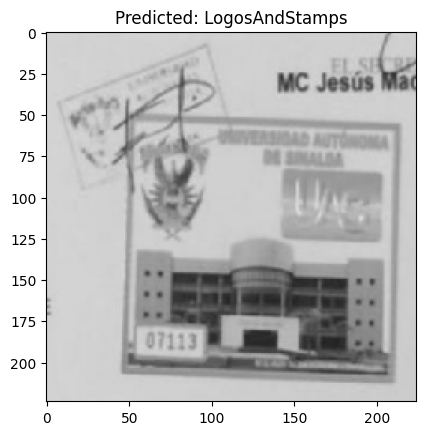

1/1 [==============================] - 0s 79ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 1.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 0.0000


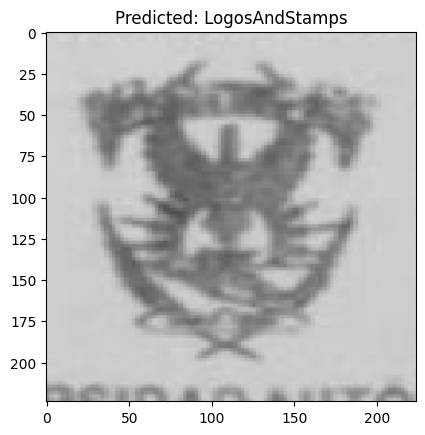

1/1 [==============================] - 0s 71ms/step
Class: BarCodes, Confidence: 0.0000
Class: Graphs, Confidence: 0.0000
Class: LogosAndStamps, Confidence: 0.0000
Class: Photographs, Confidence: 0.0000
Class: QRcodes, Confidence: 0.0000
Class: Signatures, Confidence: 1.0000


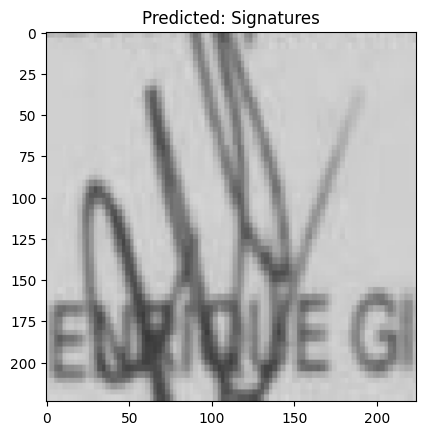

In [9]:
# Test the model with samples images
import matplotlib.pyplot as plt

img_folder = r"crops/"

for file_name in os.listdir(img_folder):

    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        
        file_path = os.path.join(img_folder, file_name)
        img = image.load_img(file_path, target_size=(224, 224))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)


        predictions = model.predict(x)
        predicted_labels = np.argmax(predictions, axis=1)

        labels = [label_to_class[label] for label in predicted_labels]
        

        confidence_scores = predictions[0]
        # Decode the results into a list of tuples (class, description, probability)
        for i, score in enumerate(confidence_scores):
            print(f"Class: {label_to_class[i]}, Confidence: {score:.4f}")


        plt.imshow(img)
        plt.title(f"Predicted: {labels[0]}")
        plt.show()